In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam


##Lectura y preparación de la base de datos

In [ ]:
data= pd.read_excel('/content/data_combined.xlsx')

In [ ]:
Labels = data['Appointment Type'].values
Features = data.drop(['Appointment Type'],axis=1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, stratify=Labels, random_state=42)

print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (19444, 12)
Train labels shape: (19444,)
Test data shape: (4862, 12)
Test labels shape: (4862,)


# Conversión a categorica

In [ ]:
y_train= tf.keras.utils.to_categorical(
    y_train, num_classes=2
)

In [ ]:
y_test= tf.keras.utils.to_categorical(
    y_test, num_classes=2
)

#Normalización

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(19444, 12)

##Ajuste de forma de entrada

In [ ]:
X_train=np.expand_dims(X_train, axis=-1)
X_test=np.expand_dims(X_test, axis=-1)

In [ ]:
X_train.shape

(19444, 12, 1)

##Métricas

In [ ]:
def evaluate_model(model, X_test, y_test, history):

    # Realizar predicciones con el modelo
    y_pred = model.predict(X_test)

    # Obtener la clase con la máxima probabilidad en las etiquetas verdaderas (y_test)
    max_prob_true = np.argmax(y_test, axis=1)

    # Obtener la clase con la máxima probabilidad en las predicciones (predict)
    max_prob_pred = np.argmax(y_pred, axis=1)

    # Calcular las métricas
    accuracy = accuracy_score(max_prob_true, max_prob_pred)
    f1 = f1_score(max_prob_true, max_prob_pred, average='weighted')
    recall = recall_score(max_prob_true, max_prob_pred, average='weighted')

    # Mostrar las métricas
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)

    # Graficar la precisión para entrenamiento y validación
    plt.plot(history.history['accuracy'], label='Train Accuracy')  # Precisión del entrenamiento
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')  # Precisión de la validación
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Graficar la pérdida para entrenamiento y validación
    plt.plot(history.history['loss'], label='Train Loss')  # Pérdida del entrenamiento
    plt.plot(history.history['val_loss'], label='Test Loss')  # Pérdida de la validación
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(max_prob_true, max_prob_pred)

    # Graficar la matriz de confusión usando seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

     # Binarizar las etiquetas verdaderas para ROC multi-clase
    y_test_bin = label_binarize(y_test, classes=np.arange(y_pred.shape[1]))

    # Número de clases
    n_classes = y_pred.shape[1]

    # Inicializar las variables para la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular fpr, tpr y AUC para cada clase
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gráfica ROC para cada clase
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Agregar la línea de referencia
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

    # Etiquetas y título del gráfico
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

##Red 1: ANN Simple- Relu

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=12, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6617 - loss: 0.6195 - val_accuracy: 0.6882 - val_loss: 0.5974
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6802 - loss: 0.5971 - val_accuracy: 0.6937 - val_loss: 0.5806
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6913 - loss: 0.5773 - val_accuracy: 0.7007 - val_loss: 0.5700
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7006 - loss: 0.5623 - val_accuracy: 0.7040 - val_loss: 0.5617
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.5633 - val_accuracy: 0.7036 - val_loss: 0.5582
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7075 - loss: 0.5488 - val_accuracy: 0.7092 - val_loss: 0.5502
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7096 - loss: 0.5455 - val_accuracy: 0.7143 - val_loss: 0.5472
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7083 - loss: 0.5417 - val_acc

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7400246812011518
F1 Score: 0.7398554703698003
Recall: 0.7400246812011518


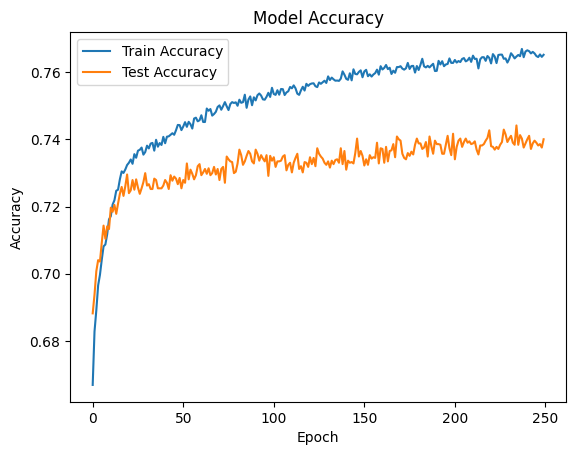

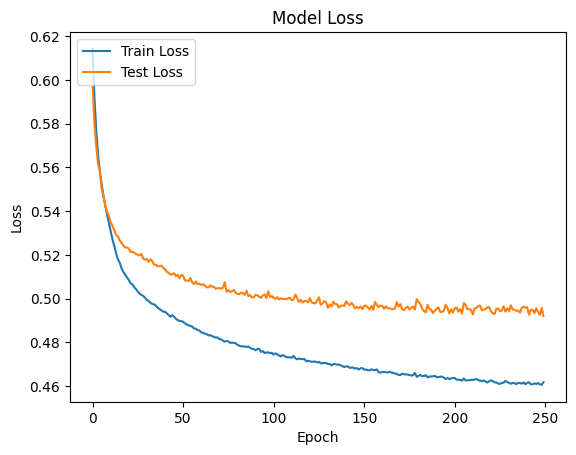

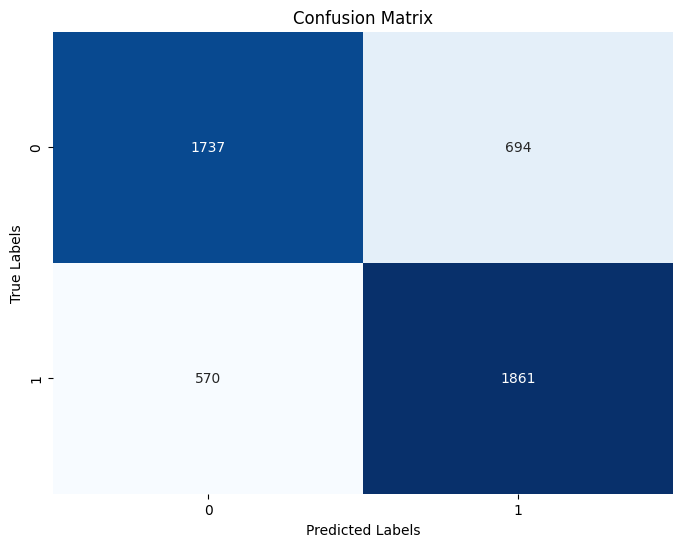

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Red 2: ANN Simple- ELU

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=12, activation="elu"))
model.add(Dense(12, activation="elu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7061 - loss: 0.5642 - val_accuracy: 0.7118 - val_loss: 0.5556
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7126 - loss: 0.5515 - val_accuracy: 0.7053 - val_loss: 0.5578
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7066 - loss: 0.5568 - val_accuracy: 0.7155 - val_loss: 0.5520
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7153 - loss: 0.5492 - val_accuracy: 0.7137 - val_loss: 0.5516
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7094 - loss: 0.5502 - val_accuracy: 0.7141 - val_loss: 0.5484
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7134 - loss: 0.5507 - val_accuracy: 0.7195 - val_loss: 0.5468
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7064 - loss: 0.5462 - val_accuracy: 0.7153 - val_loss: 0.5451
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7165 - loss: 0.5399 - val_accu

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7291238173591115
F1 Score: 0.7288038641057586
Recall: 0.7291238173591115


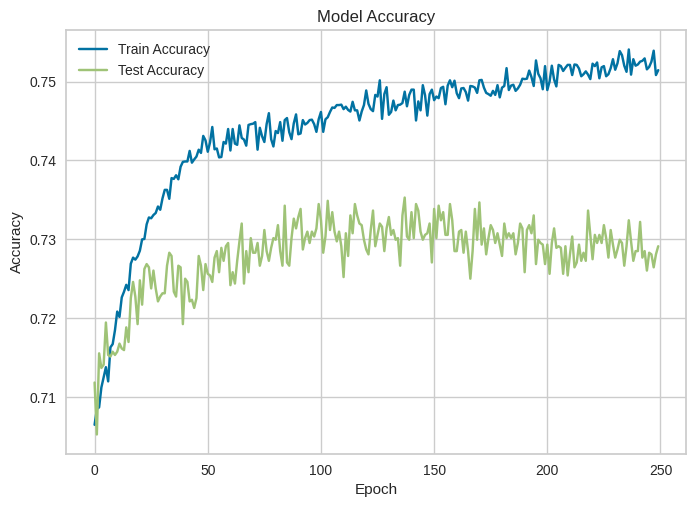

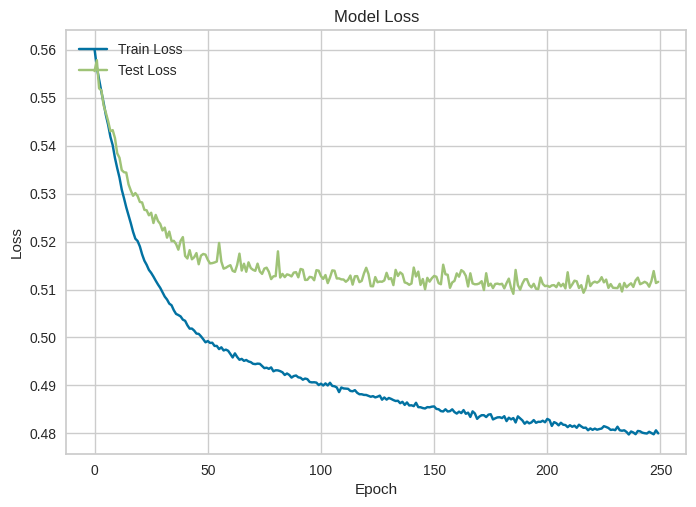

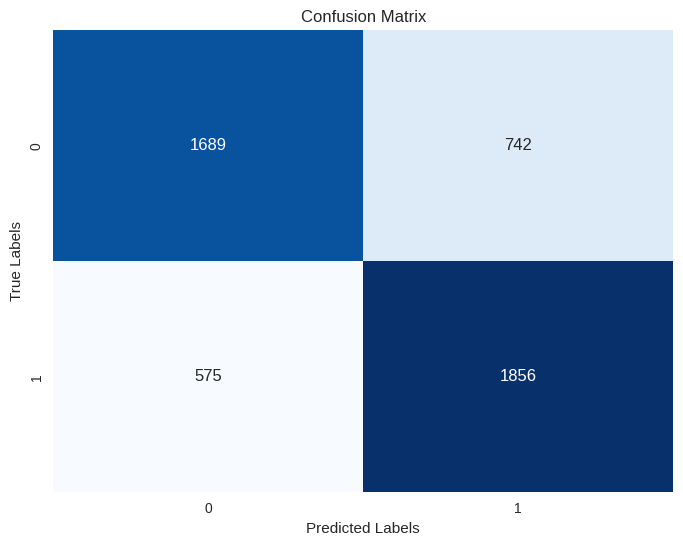

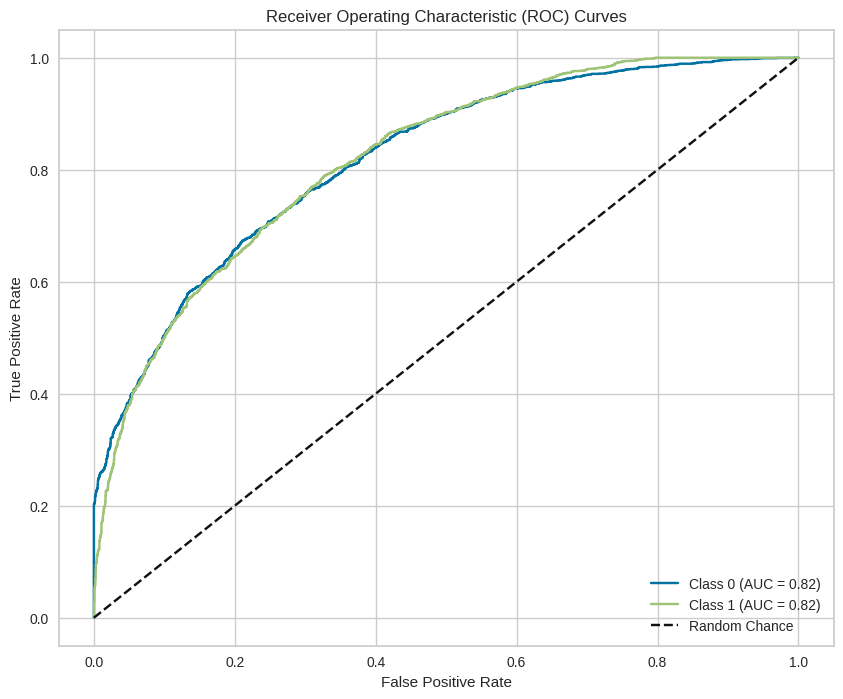

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Red 3: ANN Simple- Selu

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=12, activation="selu"))
model.add(Dense(12, activation="selu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6000 - loss: 0.6970 - val_accuracy: 0.6641 - val_loss: 0.6203
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6595 - loss: 0.6267 - val_accuracy: 0.6744 - val_loss: 0.6142
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6648 - loss: 0.6202 - val_accuracy: 0.6843 - val_loss: 0.6092
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6636 - loss: 0.6171 - val_accuracy: 0.6845 - val_loss: 0.6056
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6711 - loss: 0.6091 - val_accuracy: 0.6861 - val_loss: 0.6021
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6663 - loss: 0.6106 - val_accuracy: 0.6950 - val_loss: 0.5986
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6804 - loss: 0.5997 - val_accuracy: 0.6874 - val_loss: 0.5961
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6836 - loss: 0.5981 - val_acc

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7334430275606746
F1 Score: 0.7331243895807092
Recall: 0.7334430275606746


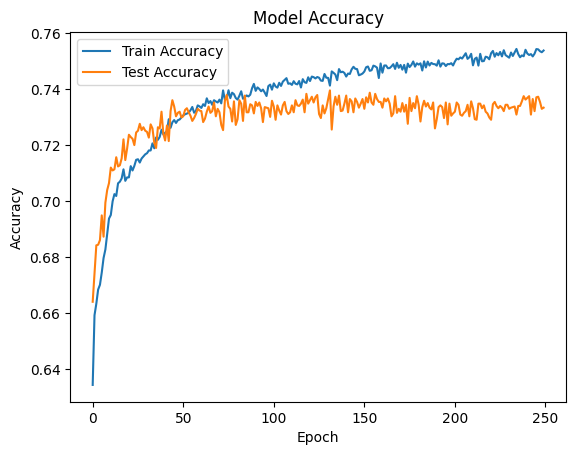

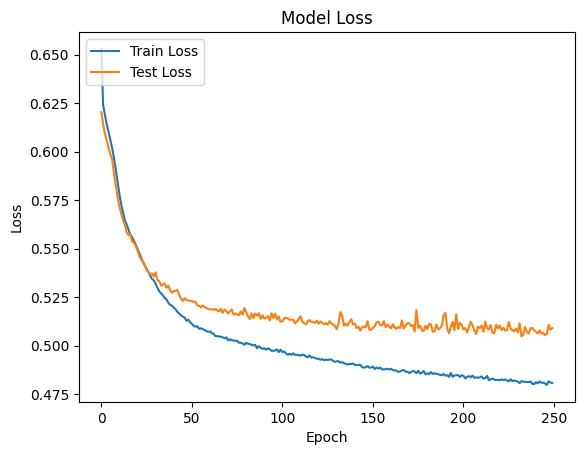

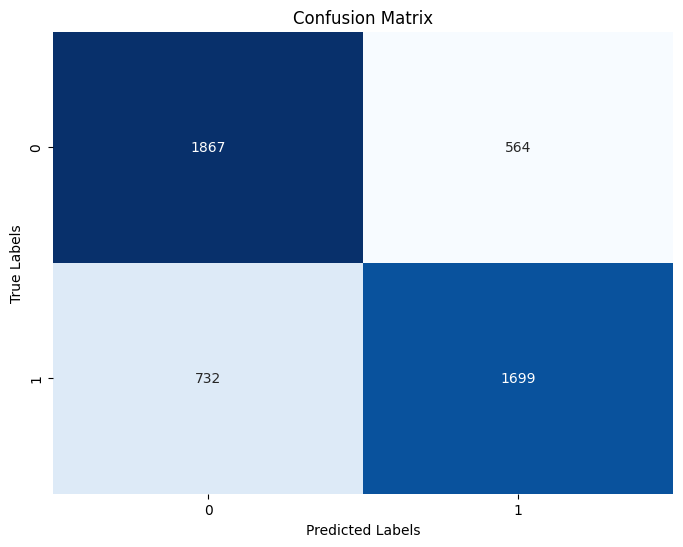

In [ ]:
evaluate_model(model, X_test, y_test, history)

**Dados los resultados anteriores, se evidencian mejores métricas mediante la función de activación RELU, por lo tanto, tomaremos está función como base para los demas hiperparametros**

##Red 4

In [ ]:
model = Sequential()

model.add(Dense(512, input_dim=12, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(16, input_dim=12, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(12, activation="relu"))


model.add(Dense(2, activation="softmax"))

learning_rate = 0.001
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


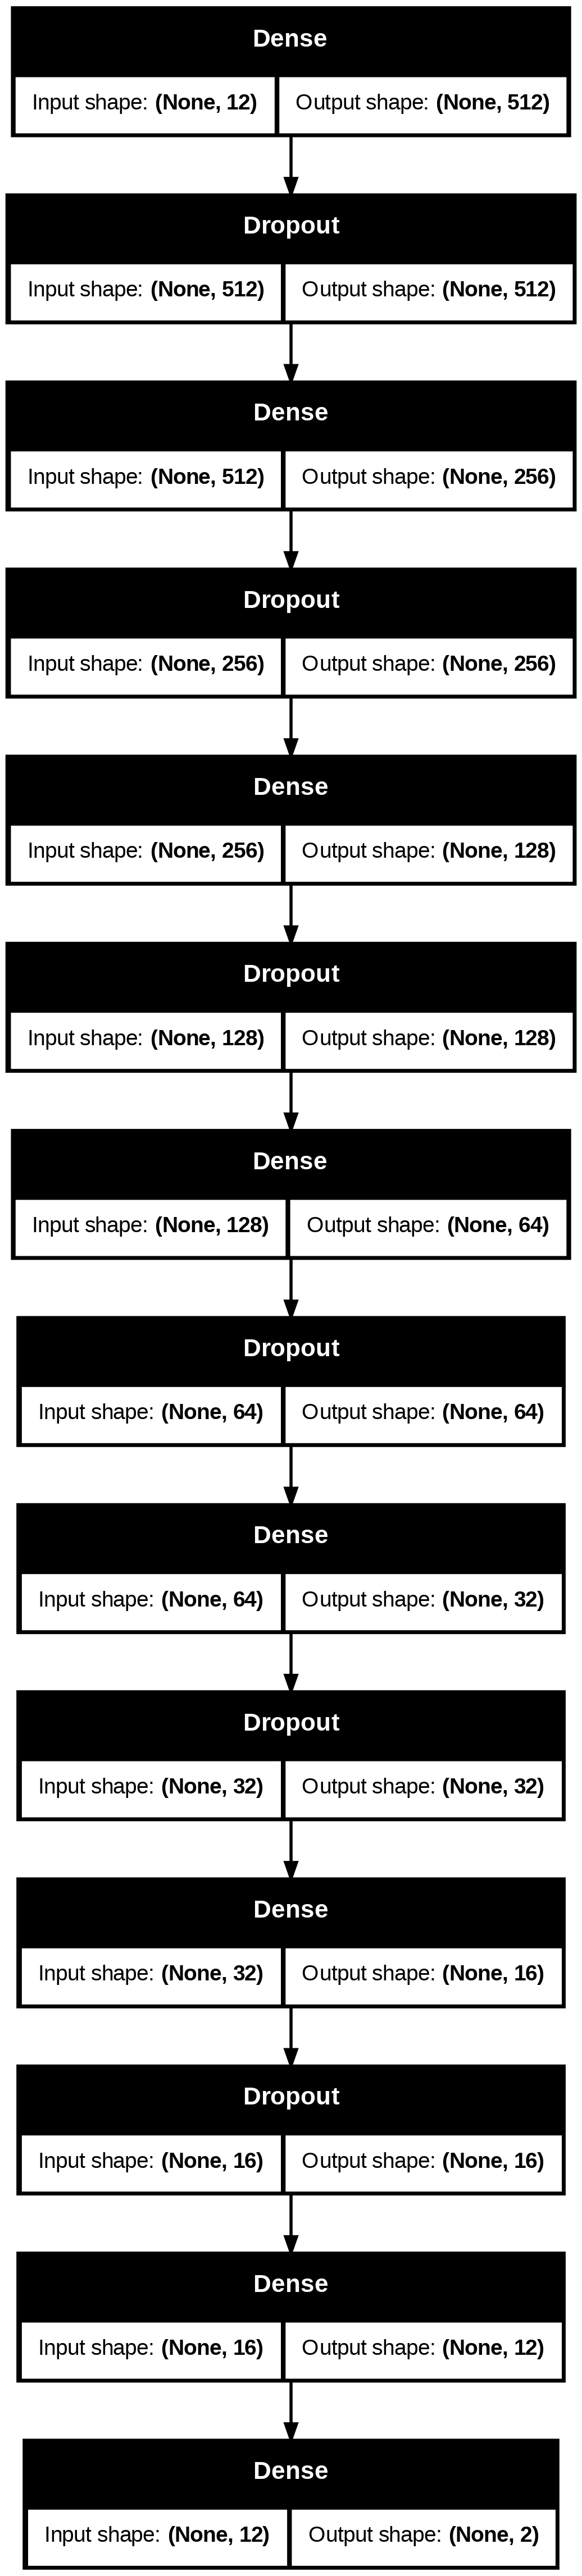

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5017 - loss: 0.6988 - val_accuracy: 0.6236 - val_loss: 0.6897
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5367 - loss: 0.6873 - val_accuracy: 0.6680 - val_loss: 0.6512
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6264 - loss: 0.6530 - val_accuracy: 0.7012 - val_loss: 0.6139
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6623 - loss: 0.6177 - val_accuracy: 0.7088 - val_loss: 0.5803
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6819 - loss: 0.5901 - val_accuracy: 0.7230 - val_loss: 0.5723
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6864 - loss: 0.5824 - val_accuracy: 0.7215 - val_loss: 0.5696
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6998 - loss: 0.5657 - val_accuracy: 0.7302 - val_loss: 0.5511
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7084 - loss: 0.5533 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7517482517482518
F1 Score: 0.7511367962368628
Recall: 0.7517482517482518


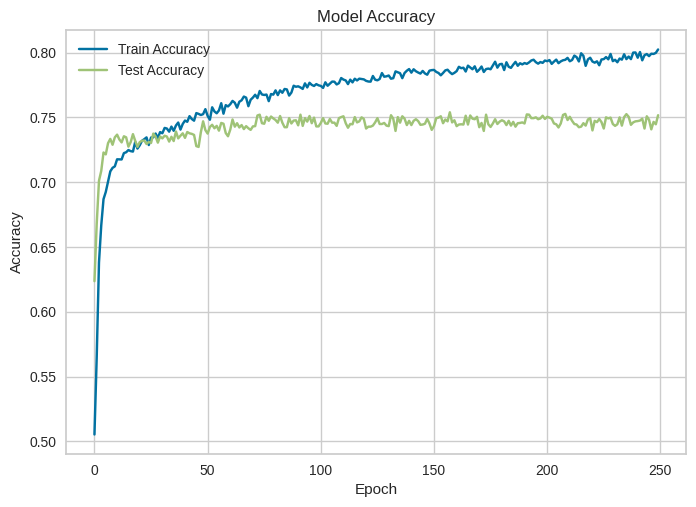

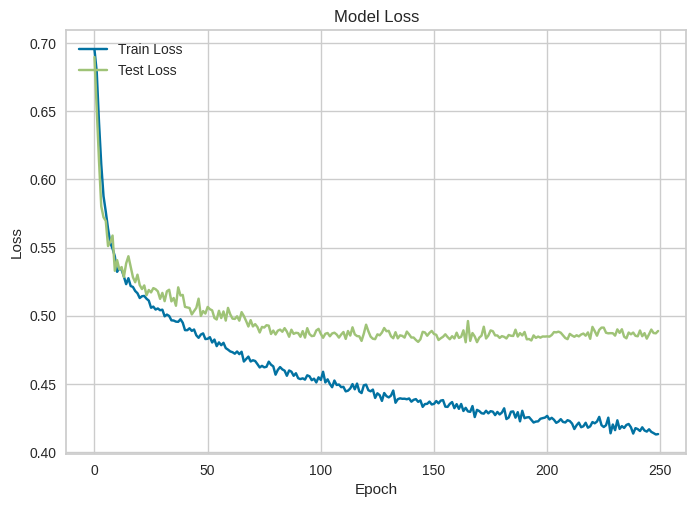

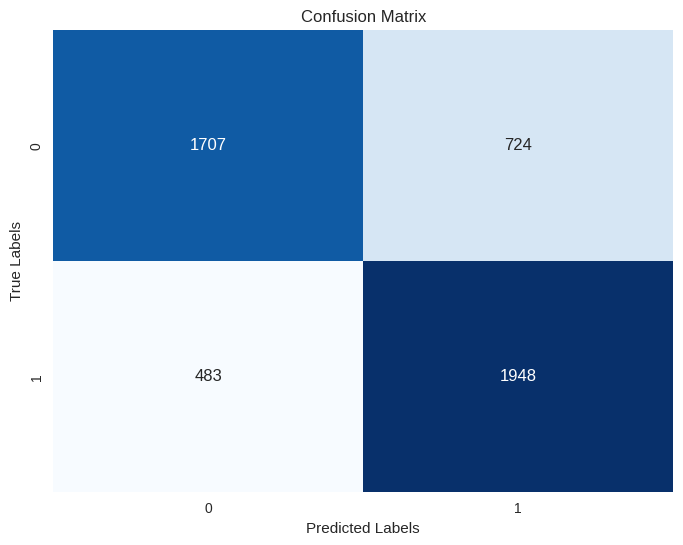

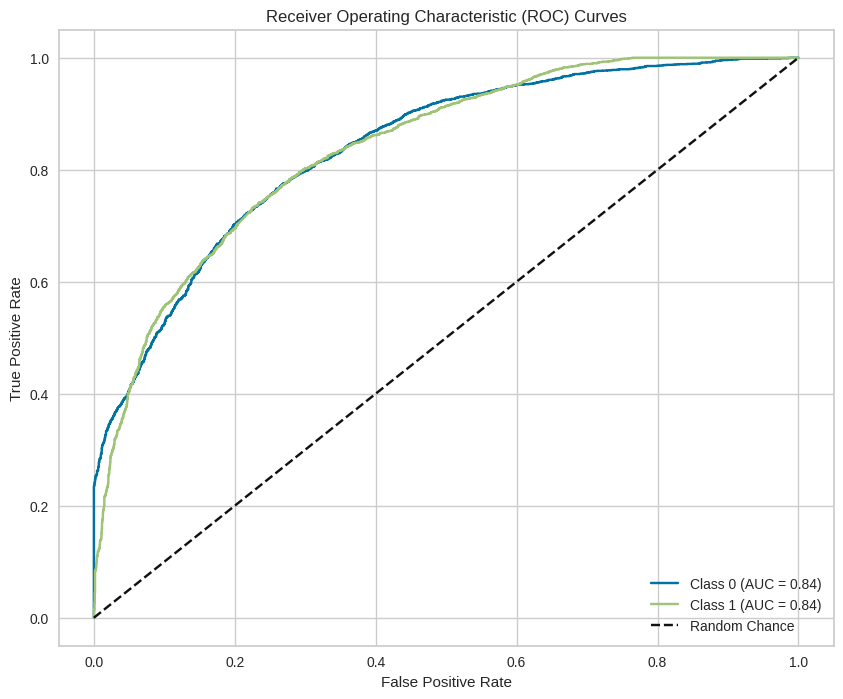

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Red 5

In [ ]:
model = Sequential()

model.add(Dense(512, input_dim=12, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(16, input_dim=12, activation="relu"))
model.add(Dense(16, input_dim=12, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(12, activation="relu"))
model.add(Dense(12, activation="relu"))



model.add(Dense(2, activation="softmax"))

learning_rate = 0.001
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.5517 - loss: 0.6832 - val_accuracy: 0.6360 - val_loss: 0.6495
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6578 - loss: 0.6223 - val_accuracy: 0.6372 - val_loss: 0.6035
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6854 - loss: 0.5789 - val_accuracy: 0.6487 - val_loss: 0.5675
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7013 - loss: 0.5562 - val_accuracy: 0.6201 - val_loss: 0.5799
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7168 - loss: 0.5389 - val_accuracy: 0.6314 - val_loss: 0.5657
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7200 - loss: 0.5297 - val_accuracy: 0.6273 - val_loss: 0.5664
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7228 - loss: 0.5292 - val_accuracy: 0.6868 - val_loss: 0.5513
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7258 - loss: 0.5263 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy: 0.7211024269847799
F1 Score: 0.7147420764860873
Recall: 0.7211024269847799


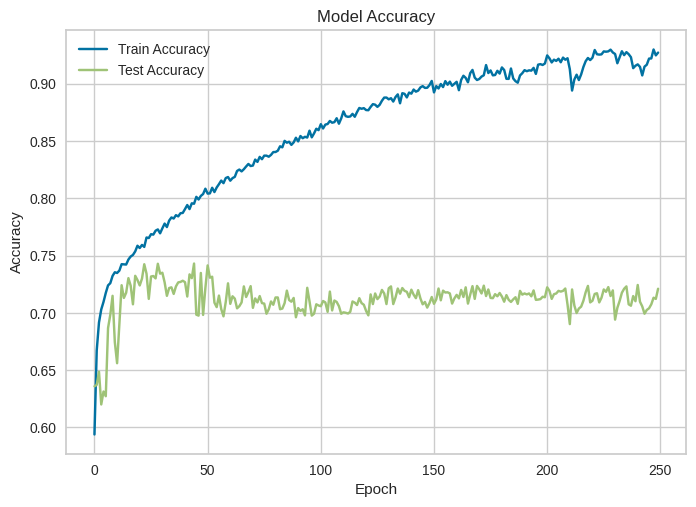

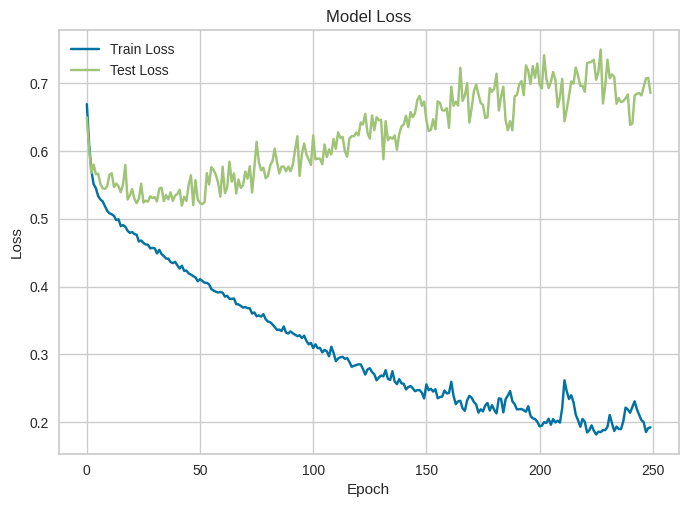

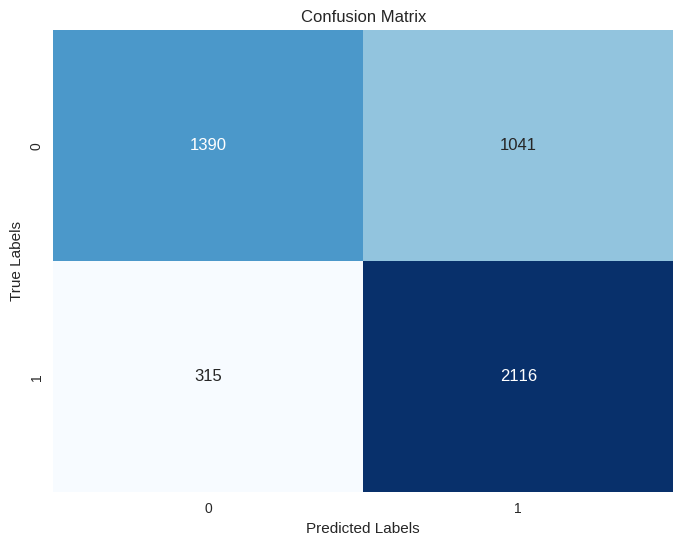

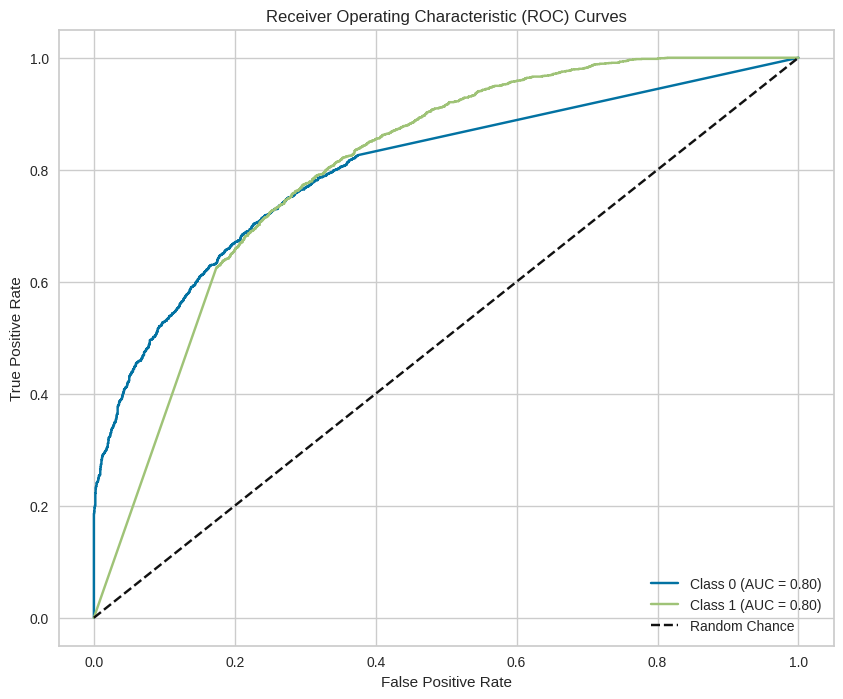

In [ ]:
evaluate_model(model, X_test, y_test, history)

Red 5- Invertida

In [ ]:
model = Sequential()

model.add(Dense(12,input_dim=12, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(16,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512, input_dim=12, activation="relu"))


model.add(Dense(2, activation="softmax"))

learning_rate = 0.001
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.5094 - loss: 0.7022 - val_accuracy: 0.5004 - val_loss: 0.6938
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5214 - loss: 0.6914 - val_accuracy: 0.5008 - val_loss: 0.6941
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5447 - loss: 0.6864 - val_accuracy: 0.5039 - val_loss: 0.6955
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5656 - loss: 0.6774 - val_accuracy: 0.5029 - val_loss: 0.7007
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5903 - loss: 0.6705 - val_accuracy: 0.5247 - val_loss: 0.6939
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6166 - loss: 0.6578 - val_accuracy: 0.5469 - val_loss: 0.6901
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6342 - loss: 0.6473 - val_accuracy: 0.5206 - val_loss: 0.7162
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6442 - loss: 0.6387 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.6501439736733854
F1 Score: 0.6142557599188982
Recall: 0.6501439736733854


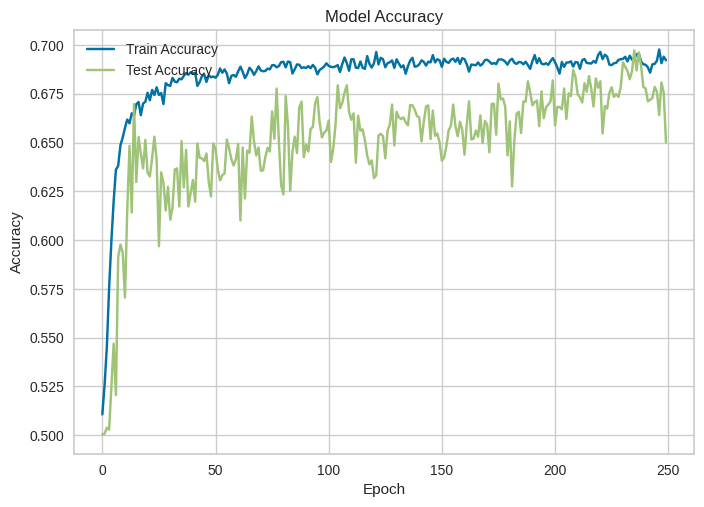

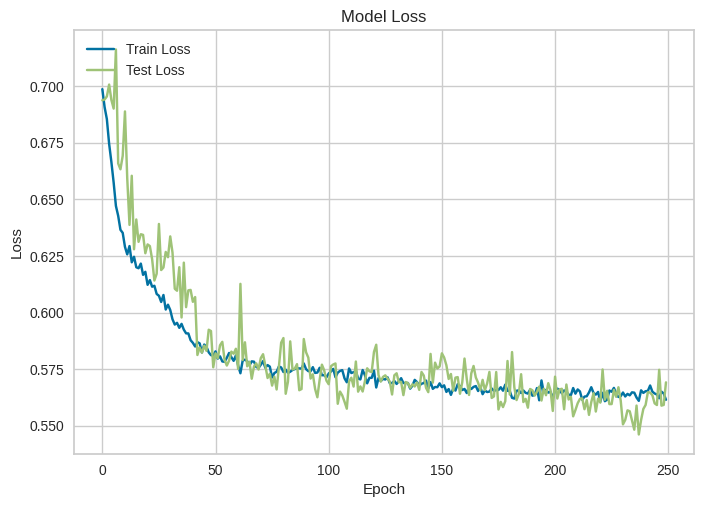

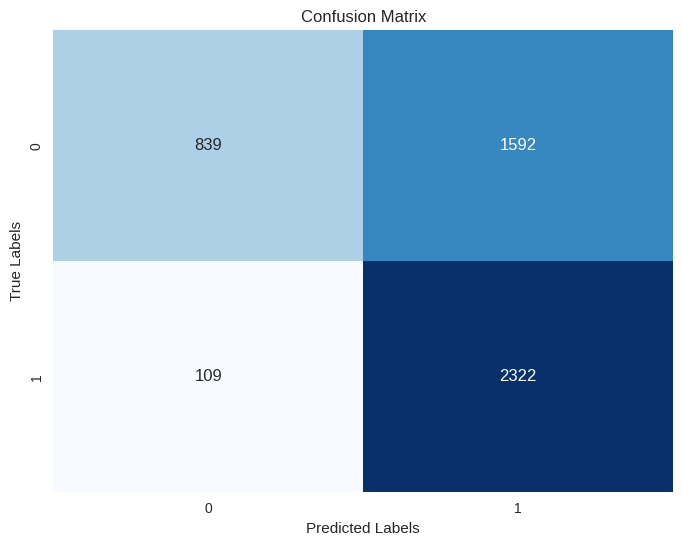

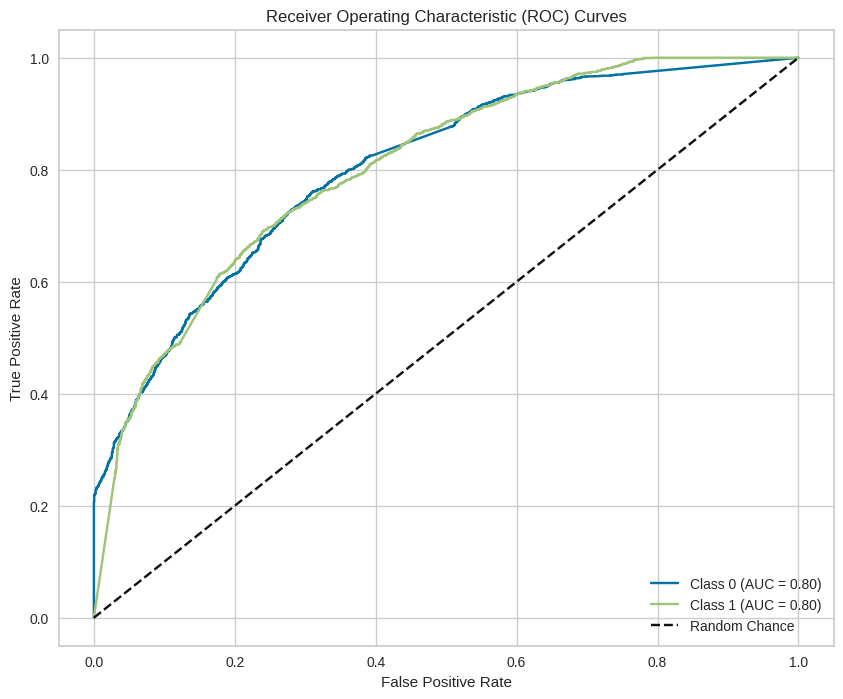

In [ ]:
evaluate_model(model, X_test, y_test, history)

In [ ]:
import numpy as np
# Matriz de confusión
confusion_matrix_values = np.array([
    [1707, 724],
    [483, 1984]
])

# Calcular la matriz de confusión en porcentaje por filas
conf_matrix_percent = confusion_matrix_values.astype('float') / confusion_matrix_values.sum(axis=1)[:, np.newaxis] * 100

# Mostrar la matriz en porcentajes
print(conf_matrix_percent)

[[70.21801728 29.78198272]
 [19.57843535 80.42156465]]
